# Analysis of the NNI experiment data

Import dependencies -- numpy, pandas, scipy.stats, matplotlib.pyplot, seaborn, pathlib, plotly.express

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

Function to calculate number of trials needed to solve problem in each experiment (i.e. how many trials needed to reach goal rolling mean)

In [2]:
def trials_to_goal(data, goal):
    ## create list for storing trial indices
    goal_reached = []
    
    ## for each value in roll_mean, record the index of values > goal
    for i in range(len(data)):
        a=[index for index,val in enumerate(data['roll_mean'][i]) if val > goal]
        
        ## if experiment never reached goal, put max number of runs in list
        if len(a) < 1:
            goal_reached.append(2000)
        ## otherwise, add the index to the list for plotting
        else:
            goal_reached.append(a[0])
        
    ## return list 
    return goal_reached

Function for creating a new dataframe with just the 'best' 2% of experiments. I.e. the 2% of experiments that reached the goal rolling mean in the fewest learning trials.

In [3]:
def get_best(dataframe, params_list):
    ## Set a threshold for getting the quickest experiments
    top_2per = int(len(dataframe)*0.02)
    
    ## Generate new dataframe containing only the experiments that achieved the goal rolling mean 
    ## quicker than the threshold number of trials
    best = dataframe.nsmallest(top_2per, ['goal_reached'])
    best = best.reset_index()
        
    ## return new data frame
    return best

Function for creating a dataframe containing data from all of the experiments which used the 'best' performing parameter value combinations

In [4]:
def get_all_best_params(main_df, param_sets_df, param_list):
    ## for each parameter that was tested
    for p in param_list:
        
        ## initialise new data frame with the alpha parameter
        if p == 'alpha ':
            ## get minimum and maximum values of alpha
            max_v = param_sets_df[p].max()
            min_v = param_sets_df[p].min()
            
            ## find all instances of alpha values in this range being tested and create a new dataframe
            in_range = main_df.loc[(main_df[p] <= max_v) & 
                                   (main_df['alpha '] >= min_v)]
        
        ## for all other parameters
        else:
            ## get minimum and maximum values of the parameter
            max_v = param_sets_df[p].max()
            min_v = param_sets_df[p].min()
            
            ## restrict the data frame to instances where the tested value for this parameter were inside this range
            in_range = in_range.loc[(in_range[p] <= max_v) & 
                                    (in_range[p] >= min_v)]
        
        ## return new data frame
        return in_range

Function for retrieving the reward schedules for each of the 'best' experiments

In [5]:
def get_best_reward_schedules(dataframe):
    
    ## remove square brackets from the data contained in the 'episodes ' column
    dataframe['episodes '] = dataframe['episodes '].str.replace('[','')
    dataframe['episodes '] = dataframe['episodes '].str.replace(']','')
    
    ## for each row in the data frame
    for i in range (len(dataframe)):
        ## data contained in each row of this column is currently a single string.
        ## create individual strings for each numerical value by separating after each comma
        dataframe['episodes '][i] = dataframe['episodes '][i].split(',')
        
        ## convert all values from strings to floats
        dataframe['episodes '][i] = pd.to_numeric(dataframe["episodes "][i], downcast="float")
        
    ## return data frame 
    return dataframe

Set path to data

In [6]:
data_folder = Path('./data/')

## TD(0) Analysis
<br>
Load dataframes

In [7]:
mg_0_base =  pd.read_pickle(data_folder/'MG_TD0_Baseline_long_dataframe') # baseline condition
mg_0_1h =  pd.read_pickle(data_folder/'MG_TD0_1H_long_dataframe')         # 1 hot condition
mg_0_ssp =  pd.read_pickle(data_folder/'MG_TD0_SSP_long_dataframe')       # SSP condition
mg_0_grid =  pd.read_pickle(data_folder/'MG_TD0_Grid_long_dataframe')     # grid cell condition

Add a column showing how many learning trials it took to reach the goal of a rolling average reward of 0.95 over the last 100 trials

In [8]:
## set goal value
goal = 0.95

## generate list of how quickly the goal was reached in each experiment
goal_reached = trials_to_goal(mg_0_base, goal)
## add this list to dataframe as new column
mg_0_base['goal_reached'] = goal_reached

## Repeat for each representation ##
## 1 hot
goal_reached = trials_to_goal(mg_0_1h, goal)
mg_0_1h['goal_reached'] = goal_reached

## SSP
goal_reached = trials_to_goal(mg_0_ssp, goal)
mg_0_ssp['goal_reached'] = goal_reached

## grid cell
goal_reached = trials_to_goal(mg_0_grid, goal)
mg_0_grid['goal_reached'] = goal_reached

Convert values in dataframe from object to numeric

In [9]:
mg_0_base["alpha "] = pd.to_numeric(mg_0_base["alpha "], downcast="float")
mg_0_1h["alpha "] = pd.to_numeric(mg_0_1h["alpha "], downcast="float")
mg_0_ssp["alpha "] = pd.to_numeric(mg_0_ssp["alpha "], downcast="float")
mg_0_grid["alpha "] = pd.to_numeric(mg_0_grid["alpha "], downcast="float")

mg_0_base["beta "] = pd.to_numeric(mg_0_base["beta "], downcast="float")
mg_0_1h["beta "] = pd.to_numeric(mg_0_1h["beta "], downcast="float")
mg_0_ssp["beta "] = pd.to_numeric(mg_0_ssp["beta "], downcast="float")
mg_0_grid["beta "] = pd.to_numeric(mg_0_grid["beta "], downcast="float")

mg_0_base["gamma "] = pd.to_numeric(mg_0_base["gamma "], downcast="float")
mg_0_1h["gamma "] = pd.to_numeric(mg_0_1h["gamma "], downcast="float")
mg_0_ssp["gamma "] = pd.to_numeric(mg_0_ssp["gamma "], downcast="float")
mg_0_grid["gamma "] = pd.to_numeric(mg_0_grid["gamma "], downcast="float")

mg_0_1h["n_neurons "] = pd.to_numeric(mg_0_1h["n_neurons "], downcast="float")
mg_0_ssp["n_neurons "] = pd.to_numeric(mg_0_ssp["n_neurons "], downcast="float")
mg_0_grid["n_neurons "] = pd.to_numeric(mg_0_grid["n_neurons "], downcast="float")

mg_0_1h["sparsity "] = pd.to_numeric(mg_0_1h["sparsity "], downcast="float")
mg_0_ssp["sparsity "] = pd.to_numeric(mg_0_ssp["sparsity "], downcast="float")
mg_0_grid["sparsity "] = pd.to_numeric(mg_0_grid["sparsity "], downcast="float")

mg_0_ssp["dims "] = pd.to_numeric(mg_0_ssp["dims "], downcast="float")

mg_0_base["goal_reached"] = pd.to_numeric(mg_0_base["goal_reached"], downcast="float")
mg_0_1h["goal_reached"] = pd.to_numeric(mg_0_1h["goal_reached"], downcast="float")
mg_0_ssp["goal_reached"] = pd.to_numeric(mg_0_ssp["goal_reached"], downcast="float")
mg_0_grid["goal_reached"] = pd.to_numeric(mg_0_grid["goal_reached"], downcast="float")

### TD(0) - Plot optimization curves

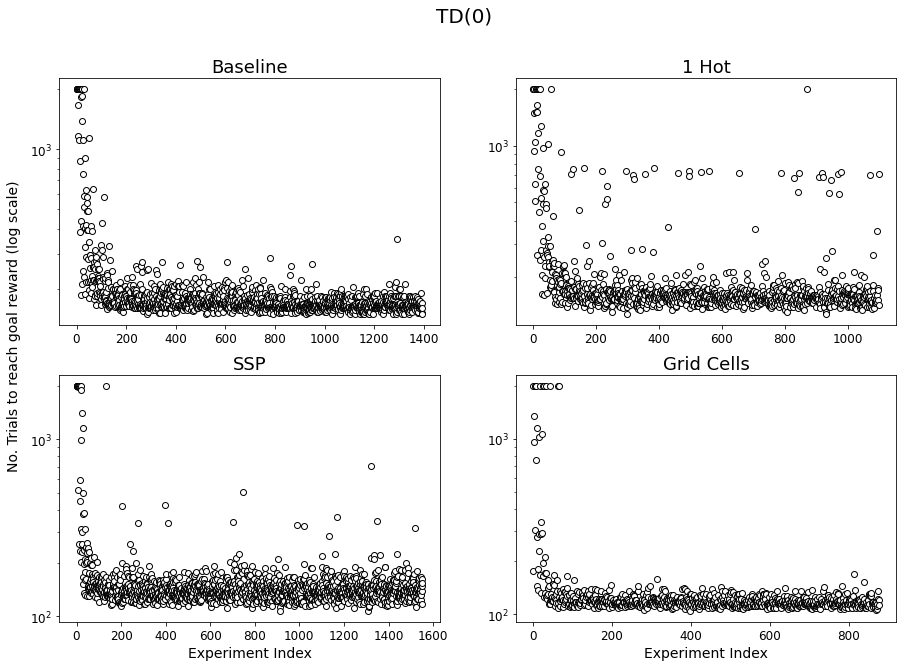

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('TD(0)', fontsize=20)

ax1.scatter(mg_0_base.index, mg_0_base['goal_reached'], color = 'white', edgecolors = 'black')
ax1.set_title('Baseline', fontsize=18)
ax1.set_ylabel('No. Trials to reach goal reward (log scale)', fontsize=14)
ax1.yaxis.set_label_coords(-.1, 0)
ax1.set_yscale('log')
ax1.tick_params(labelsize = 12)

ax2.scatter(mg_0_1h.index, mg_0_1h['goal_reached'], color = 'white', edgecolors = 'black')
ax2.set_title('1 Hot', fontsize=18)
ax2.set_yscale('log')
ax2.tick_params(labelsize = 12)

ax3.scatter(mg_0_ssp.index, mg_0_ssp['goal_reached'], color = 'white', edgecolors = 'black')
ax3.set_title('SSP', fontsize=18)
ax3.set_xlabel('Experiment Index', fontsize=14)
ax3.set_yscale('log')
ax3.tick_params(labelsize = 12)

ax4.scatter(mg_0_grid.index, mg_0_grid['goal_reached'], color = 'white', edgecolors = 'black')
ax4.set_title('Grid Cells', fontsize=18)
ax4.set_xlabel('Experiment Index', fontsize=14)
ax4.set_yscale('log')
ax4.tick_params(labelsize = 12)

## save figure
fig.savefig("./figures/nni_td0_optim.pdf", bbox_inches="tight")

Print the minimum number of trials needed to reach goal for each representation

In [11]:
print('Minimum no. trials to reach goal.')
print('   Baseline:', mg_0_base['goal_reached'].min())
print('   One Hot:', mg_0_1h['goal_reached'].min())
print('   SSP:', mg_0_ssp['goal_reached'].min())
print('   Grid Cells:', mg_0_grid['goal_reached'].min())

Minimum no. trials to reach goal.
   Baseline: 149.0
   One Hot: 127.0
   SSP: 108.0
   Grid Cells: 105.0


### TD(0) - 'Best' Parameter Value Combinations
<br>
Let's have a look at the 'best' parameter sets - the parameter values that achieved the goal rolling mean in the fewest learning trials

In [12]:
## Create dataframes containing the 'best' 2% of nni experiments 
mg_0_base_best = get_best(mg_0_base, ['alpha ', 'beta ', 'gamma '])
mg_0_1h_best = get_best(mg_0_1h, ['alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity '])
mg_0_ssp_best = get_best(mg_0_ssp, ['alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity ', 'dims '])
mg_0_grid_best = get_best(mg_0_grid, ['alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity '])

Show the experiments that were in this top 2% for each condition

In [13]:
print('Baseline Representation')
print(len(mg_0_base_best), 'experiments achieved goal in under', mg_0_base_best['goal_reached'].max(), 'trials.')

param_sets_base = mg_0_base_best[['index', 'alpha ','beta ','gamma ', 'goal_reached']]
param_sets_base.drop_duplicates()

Baseline Representation
27 experiments achieved goal in under 150.0 trials.


,index,alpha,beta,gamma,goal_reached
0,282,0.876632,0.796175,0.968183,149.0
1,521,0.878393,0.800871,0.967785,149.0
2,792,0.871461,0.803492,0.958463,149.0
3,923,0.877810,0.803241,0.967343,149.0
4,1030,0.876548,0.805166,0.967153,149.0
5,1061,0.877203,0.804130,0.967573,149.0
6,1104,0.875569,0.803844,0.967329,149.0
7,1123,0.873027,0.803307,0.968231,149.0
8,1141,0.876719,0.808535,0.966280,149.0
9,1153,0.876263,0.803127,0.967090,149.0


In [14]:
print('One-Hot Representation')
print(len(mg_0_1h_best), 'experiments achieved goal in under', mg_0_1h_best['goal_reached'].max(), 'trials.')

param_sets_1h = mg_0_1h_best[['index', 'alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity ', 'goal_reached']]
param_sets_1h.drop_duplicates()

One-Hot Representation
22 experiments achieved goal in under 136.0 trials.


,index,alpha,beta,gamma,n_neurons,sparsity,goal_reached
0,299,0.814139,0.721610,0.984446,4427.0,0.570108,127.0
1,933,0.814364,0.740940,0.988224,4427.0,0.560406,127.0
2,252,0.818087,0.732094,0.988484,4427.0,0.573737,131.0
3,808,0.819738,0.719528,0.986181,4427.0,0.573528,131.0
4,931,0.814355,0.728091,0.991994,4427.0,0.573823,131.0
5,181,0.813838,0.738744,0.975205,4427.0,0.549486,133.0
6,341,0.816230,0.738066,0.986043,4427.0,0.557056,133.0
7,442,0.807030,0.721075,0.994825,4427.0,0.575658,133.0
8,801,0.818447,0.736449,0.987286,4427.0,0.568129,134.0
9,861,0.820128,0.730195,0.987275,4427.0,0.576870,134.0


In [15]:
print('SSP Representation')
print(len(mg_0_ssp_best), 'experiments achieved goal in under', mg_0_ssp_best['goal_reached'].max(), 'trials.')

param_sets_ssp = mg_0_ssp_best[['index', 'alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity ', 'dims ', 'goal_reached']]
param_sets_ssp.drop_duplicates()

SSP Representation
31 experiments achieved goal in under 116.0 trials.


,index,alpha,beta,gamma,n_neurons,sparsity,dims,goal_reached
0,913,0.843752,0.859116,0.964782,4835.0,0.247326,64.0,108.0
1,1309,0.853459,0.860173,0.964998,4835.0,0.238026,64.0,108.0
2,676,0.852648,0.858043,0.962690,4835.0,0.237859,64.0,111.0
3,788,0.850956,0.859407,0.968933,4835.0,0.234033,64.0,111.0
4,1165,0.855939,0.858997,0.963031,4835.0,0.239902,64.0,112.0
5,1246,0.846223,0.855727,0.961310,4835.0,0.246589,64.0,112.0
6,603,0.849200,0.858099,0.968037,4835.0,0.243717,64.0,113.0
7,837,0.857620,0.861998,0.967040,4835.0,0.236260,64.0,113.0
8,911,0.853319,0.856647,0.967560,4835.0,0.241168,64.0,113.0
9,1312,0.853252,0.858428,0.965703,4835.0,0.235453,64.0,113.0


In [16]:
print('Grid-Cell Representation')
print(len(mg_0_grid_best), 'experiments achieved goal in under', mg_0_grid_best['goal_reached'].max(), 'trials.')

param_sets_grid = mg_0_grid_best[['index', 'alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity ', 'goal_reached']]
param_sets_grid.drop_duplicates()

Grid-Cell Representation
17 experiments achieved goal in under 108.0 trials.


,index,alpha,beta,gamma,n_neurons,sparsity,goal_reached
0,398,0.559759,0.870084,0.978093,4297.0,0.148526,105.0
1,281,0.557993,0.849490,0.955785,4297.0,0.143480,106.0
2,869,0.563019,0.886649,0.984698,4297.0,0.154388,106.0
3,353,0.545176,0.847360,0.968844,4297.0,0.136462,107.0
4,386,0.591624,0.880907,0.990096,4297.0,0.144094,107.0
5,396,0.552406,0.861505,0.966203,4297.0,0.136560,107.0
6,420,0.569264,0.878534,0.983421,4297.0,0.154895,107.0
7,475,0.555031,0.860031,0.969728,4297.0,0.154790,107.0
8,533,0.541169,0.845473,0.962915,4297.0,0.135611,107.0
9,594,0.544219,0.837889,0.967795,4297.0,0.132554,107.0


Table of Ranges -- create a table showing the range of values in the top 2% for each parameter

In [17]:
param_sets_combined = pd.DataFrame(columns=['TD0_Base', 'TD0_1H', 'TD0_SSP', 'TD0_Grid'],
                                    index=['alpha', 'alpha_range', 'beta', 'beta_range', 
                                            'gamma', 'gamma_range', 'neurons', 'neurons_range', 
                                            'sparsity', 'sparsity_range', 'dims', 'dims_range', 
                                            'nTrials', 'nTrials_range'])

param_sets_combined.loc['alpha','TD0_Base'] = param_sets_base['alpha '].min(), param_sets_base['alpha '].max()
param_sets_combined.loc['alpha_range','TD0_Base'] = param_sets_base['alpha '].max() - param_sets_base['alpha '].min()
param_sets_combined.loc['beta','TD0_Base'] = param_sets_base['beta '].min(), param_sets_base['beta '].max()
param_sets_combined.loc['beta_range','TD0_Base'] = param_sets_base['beta '].max() - param_sets_base['beta '].min()
param_sets_combined.loc['gamma','TD0_Base'] = param_sets_base['gamma '].min(), param_sets_base['gamma '].max()
param_sets_combined.loc['gamma_range','TD0_Base'] = param_sets_base['gamma '].max() - param_sets_base['gamma '].min()
param_sets_combined.loc['nTrials','TD0_Base'] = param_sets_base['goal_reached'].min(), param_sets_base['goal_reached'].max()
param_sets_combined.loc['nTrials_range','TD0_Base'] = param_sets_base['goal_reached'].max() - param_sets_base['goal_reached'].min()

param_sets_combined.loc['alpha','TD0_1H'] = param_sets_1h['alpha '].min(), param_sets_1h['alpha '].max()
param_sets_combined.loc['alpha_range','TD0_1H'] = param_sets_1h['alpha '].max() - param_sets_1h['alpha '].min()
param_sets_combined.loc['beta','TD0_1H'] = param_sets_1h['beta '].min(), param_sets_1h['beta '].max()
param_sets_combined.loc['beta_range','TD0_1H'] = param_sets_1h['beta '].max() - param_sets_1h['beta '].min()
param_sets_combined.loc['gamma','TD0_1H'] = param_sets_1h['gamma '].min(), param_sets_1h['gamma '].max()
param_sets_combined.loc['gamma_range','TD0_1H'] = param_sets_1h['gamma '].max() - param_sets_1h['gamma '].min()
param_sets_combined.loc['neurons','TD0_1H'] = param_sets_1h['n_neurons '].min(), param_sets_1h['n_neurons '].max()
param_sets_combined.loc['neurons_range','TD0_1H'] = param_sets_1h['n_neurons '].max() - param_sets_1h['n_neurons '].min()
param_sets_combined.loc['sparsity','TD0_1H'] = param_sets_1h['sparsity '].min(), param_sets_1h['sparsity '].max()
param_sets_combined.loc['sparsity_range','TD0_1H'] = param_sets_1h['sparsity '].max() - param_sets_1h['sparsity '].min()
param_sets_combined.loc['nTrials','TD0_1H'] = param_sets_1h['goal_reached'].min(), param_sets_1h['goal_reached'].max()
param_sets_combined.loc['nTrials_range','TD0_1H'] = param_sets_1h['goal_reached'].max() - param_sets_1h['goal_reached'].min()

param_sets_combined.loc['alpha','TD0_SSP'] = param_sets_ssp['alpha '].min(), param_sets_ssp['alpha '].max()
param_sets_combined.loc['alpha_range','TD0_SSP'] = param_sets_ssp['alpha '].max() - param_sets_ssp['alpha '].min()
param_sets_combined.loc['beta','TD0_SSP'] = param_sets_ssp['beta '].min(), param_sets_ssp['beta '].max()
param_sets_combined.loc['beta_range','TD0_SSP'] = param_sets_ssp['beta '].max() - param_sets_ssp['beta '].min()
param_sets_combined.loc['gamma','TD0_SSP'] = param_sets_ssp['gamma '].min(), param_sets_ssp['gamma '].max()
param_sets_combined.loc['gamma_range','TD0_SSP'] = param_sets_ssp['gamma '].max() - param_sets_ssp['gamma '].min()
param_sets_combined.loc['neurons','TD0_SSP'] = param_sets_ssp['n_neurons '].min(), param_sets_ssp['n_neurons '].max()
param_sets_combined.loc['neurons_range','TD0_SSP'] = param_sets_ssp['n_neurons '].max() - param_sets_ssp['n_neurons '].min()
param_sets_combined.loc['sparsity','TD0_SSP'] = param_sets_ssp['sparsity '].min(), param_sets_ssp['sparsity '].max()
param_sets_combined.loc['sparsity_range','TD0_SSP'] = param_sets_ssp['sparsity '].max() - param_sets_ssp['sparsity '].min()
param_sets_combined.loc['dims','TD0_SSP'] = param_sets_ssp['dims '].min(), param_sets_ssp['dims '].max()
param_sets_combined.loc['dims_range','TD0_SSP'] = param_sets_ssp['dims '].max() - param_sets_ssp['dims '].min()
param_sets_combined.loc['nTrials','TD0_SSP'] = param_sets_ssp['goal_reached'].min(), param_sets_ssp['goal_reached'].max()
param_sets_combined.loc['nTrials_range','TD0_SSP'] = param_sets_ssp['goal_reached'].max() - param_sets_ssp['goal_reached'].min()

param_sets_combined.loc['alpha','TD0_Grid'] = param_sets_grid['alpha '].min(), param_sets_grid['alpha '].max()
param_sets_combined.loc['alpha_range','TD0_Grid'] = param_sets_grid['alpha '].max() - param_sets_grid['alpha '].min()
param_sets_combined.loc['beta','TD0_Grid'] = param_sets_grid['beta '].min(), param_sets_grid['beta '].max()
param_sets_combined.loc['beta_range','TD0_Grid'] = param_sets_grid['beta '].max() - param_sets_grid['beta '].min()
param_sets_combined.loc['gamma','TD0_Grid'] = param_sets_grid['gamma '].min(), param_sets_grid['gamma '].max()
param_sets_combined.loc['gamma_range','TD0_Grid'] = param_sets_grid['gamma '].max() - param_sets_grid['gamma '].min()
param_sets_combined.loc['neurons','TD0_Grid'] = param_sets_grid['n_neurons '].min(), param_sets_grid['n_neurons '].max()
param_sets_combined.loc['neurons_range','TD0_Grid'] = param_sets_grid['n_neurons '].max() - param_sets_grid['n_neurons '].min()
param_sets_combined.loc['sparsity','TD0_Grid'] = param_sets_grid['sparsity '].min(), param_sets_grid['sparsity '].max()
param_sets_combined.loc['sparsity_range','TD0_Grid'] = param_sets_grid['sparsity '].max() - param_sets_grid['sparsity '].min()
param_sets_combined.loc['nTrials','TD0_Grid'] = param_sets_grid['goal_reached'].min(), param_sets_grid['goal_reached'].max()
param_sets_combined.loc['nTrials_range','TD0_Grid'] = param_sets_grid['goal_reached'].max() - param_sets_grid['goal_reached'].min()
param_sets_combined

,TD0_Base,TD0_1H,TD0_SSP,TD0_Grid
alpha,"(0.8714607357978821, 0.8881558775901794)","(0.8070295453071594, 0.8232634663581848)","(0.7939289212226868, 0.8576204776763916)","(0.5411689281463623, 0.5916241407394409)"
alpha_range,0.016695,0.016234,0.063692,0.050455
beta,"(0.789538562297821, 0.8328880667686462)","(0.7149285078048706, 0.7409399747848511)","(0.8188507556915283, 0.8723630309104919)","(0.8378887176513672, 0.8866490721702576)"
beta_range,0.04335,0.026011,0.053512,0.04876
gamma,"(0.9404892325401306, 0.9704591035842896)","(0.97520512342453, 0.9948246479034424)","(0.9470446705818176, 0.9877324104309082)","(0.9557847380638123, 0.9900961518287659)"
gamma_range,0.02997,0.01962,0.040688,0.034311
neurons,NaN,"(4427.0, 4427.0)","(4835.0, 4835.0)","(4297.0, 4297.0)"
neurons_range,NaN,0.0,0.0,0.0
sparsity,NaN,"(0.5494861602783203, 0.5788886547088623)","(0.23200882971286774, 0.24881593883037567)","(0.13255441188812256, 0.1597076654434204)"
sparsity_range,NaN,0.029402,0.016807,0.027153


Find all instances of these parameter value combinations and plot the number of trials to reach goal. This plot illustrates the stability of these parameter value combinations

In [18]:
## Create data frames containing experiments that tested value combinations 
## that were inside the ranges used in the top 2% experiments
in_range_base = get_all_best_params(mg_0_base, param_sets_base, ['alpha ', 'beta ', 'gamma '])
in_range_1h = get_all_best_params(mg_0_1h, param_sets_1h, ['alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity '])
in_range_ssp = get_all_best_params(mg_0_ssp, param_sets_ssp, ['alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity ', 'dims '])
in_range_grid = get_all_best_params(mg_0_grid, param_sets_grid, ['alpha ', 'beta ', 'gamma ', 'n_neurons ', 'sparsity '])

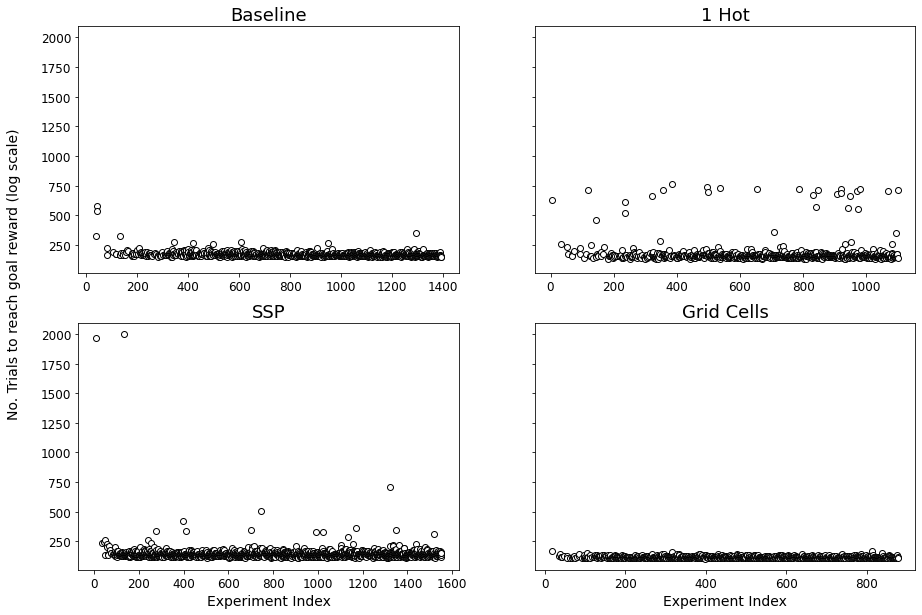

In [19]:
## Plot trials to reach goal for all of these experiments
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharey=True)

ax1.scatter(in_range_base.index, in_range_base['goal_reached'], color = 'white', edgecolors = 'black')
ax1.set_title('Baseline', fontsize=18)
ax1.set_ylabel('No. Trials to reach goal reward (log scale)', fontsize=14)
ax1.yaxis.set_label_coords(-.15, 0)
ax1.tick_params(labelsize = 12)
#ax1.set_yscale('log')

ax2.scatter(in_range_1h.index, in_range_1h['goal_reached'], color = 'white', edgecolors = 'black')
ax2.set_title('1 Hot', fontsize=18)
ax2.tick_params(labelsize = 12)
#ax2.set_yscale('log')

ax3.scatter(in_range_ssp.index, in_range_ssp['goal_reached'], color = 'white', edgecolors = 'black')
ax3.set_title('SSP', fontsize=18)
ax3.set_xlabel('Experiment Index', fontsize=14)
ax3.tick_params(labelsize = 12)
#ax3.set_yscale('log')

ax4.scatter(in_range_grid.index, in_range_grid['goal_reached'], color = 'white', edgecolors = 'black')
ax4.set_title('Grid Cells', fontsize=18)
ax4.set_xlabel('Experiment Index', fontsize=14)
ax4.tick_params(labelsize = 12)
#ax4.set_yscale('log')

## Save figure
fig.savefig("./figures/nni_td0_bestparams.pdf", bbox_inches="tight")

Finally, we need to make sure that once the goal was reached, the network continued getting rewards

In [20]:
## Extract just the reward schedules for the best 2% experiments
mg_0_base_best = get_best_reward_schedules(mg_0_base_best)
mg_0_1h_best = get_best_reward_schedules(mg_0_1h_best)
mg_0_ssp_best = get_best_reward_schedules(mg_0_ssp_best)
mg_0_grid_best = get_best_reward_schedules(mg_0_grid_best)

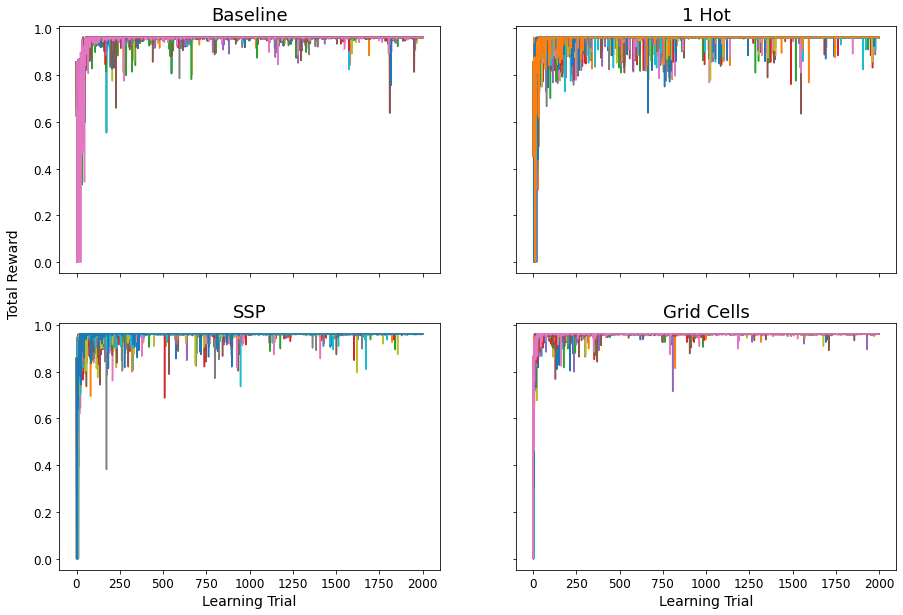

In [21]:
## Plot the reward schedules for each experiment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharey=True, sharex = True)

for i in range(len(mg_0_base_best)):
    ax1.plot(mg_0_base_best['episodes '][i])
ax1.set_title('Baseline', fontsize=18)
ax1.set_ylabel('Total Reward', fontsize=14)
ax1.yaxis.set_label_coords(-.1, 0)
ax1.tick_params(labelsize = 12)

for i in range(len(mg_0_1h_best)):
    ax2.plot(mg_0_1h_best['episodes '][i])
ax2.set_title('1 Hot', fontsize=18)
ax2.tick_params(labelsize = 12)
    
for i in range(len(mg_0_ssp_best)):
    ax3.plot(mg_0_ssp_best['episodes '][i])
ax3.set_title('SSP', fontsize=18)
ax3.set_xlabel('Learning Trial', fontsize=14)
ax3.tick_params(labelsize = 12)
    
for i in range(len(mg_0_grid_best)):
    ax4.plot(mg_0_grid_best['episodes '][i])
ax4.set_title('Grid Cells', fontsize=18)
ax4.set_xlabel('Learning Trial', fontsize=14)
ax4.tick_params(labelsize = 12)

## Save figure
fig.savefig("./figures/nni_td0_rewards.pdf", bbox_inches="tight")

## TD($\lambda$) Analysis
<br>
Load dataframes

In [22]:
mg_lam_base =  pd.read_pickle(data_folder/'MG_TDLambda_Baseline_long_dataframe') # baseline condition
mg_lam_1h =  pd.read_pickle(data_folder/'MG_TDLambda_1H_long_dataframe')         # 1 hot condition
mg_lam_ssp =  pd.read_pickle(data_folder/'MG_TDLambda_SSP_long_dataframe')       # SSP condition
mg_lam_grid =  pd.read_pickle(data_folder/'MG_TDLambda_Grid_long_dataframe')     # grid cell condition

Add a column showing how many learning trials it took to reach the goal of a rolling average reward of 0.95 over the last 100 trials

In [23]:
## set goal value
goal = 0.95

## using above function, generate list of how quickly the goal was reached in each experiment
goal_reached = trials_to_goal(mg_lam_base, goal)
## add this list to dataframe as new column
mg_lam_base['goal_reached'] = goal_reached

## Repeat for each representation
## 1 hot
goal_reached = trials_to_goal(mg_lam_1h, goal)
mg_lam_1h['goal_reached'] = goal_reached

## SSP
goal_reached = trials_to_goal(mg_lam_ssp, goal)
mg_lam_ssp['goal_reached'] = goal_reached

## grid cell
goal_reached = trials_to_goal(mg_lam_grid, goal)
mg_lam_grid['goal_reached'] = goal_reached

Convert values in dataframe from object to numeric

In [24]:
mg_lam_base["alpha "] = pd.to_numeric(mg_lam_base["alpha "], downcast="float")
mg_lam_1h["alpha "] = pd.to_numeric(mg_lam_1h["alpha "], downcast="float")
mg_lam_ssp["alpha "] = pd.to_numeric(mg_lam_ssp["alpha "], downcast="float")
mg_lam_grid["alpha "] = pd.to_numeric(mg_lam_grid["alpha "], downcast="float")

mg_lam_base["beta "] = pd.to_numeric(mg_lam_base["beta "], downcast="float")
mg_lam_1h["beta "] = pd.to_numeric(mg_lam_1h["beta "], downcast="float")
mg_lam_ssp["beta "] = pd.to_numeric(mg_lam_ssp["beta "], downcast="float")
mg_lam_grid["beta "] = pd.to_numeric(mg_lam_grid["beta "], downcast="float")

mg_lam_base["gamma "] = pd.to_numeric(mg_lam_base["gamma "], downcast="float")
mg_lam_1h["gamma "] = pd.to_numeric(mg_lam_1h["gamma "], downcast="float")
mg_lam_ssp["gamma "] = pd.to_numeric(mg_lam_ssp["gamma "], downcast="float")
mg_lam_grid["gamma "] = pd.to_numeric(mg_lam_grid["gamma "], downcast="float")

mg_lam_base["lambd "] = pd.to_numeric(mg_lam_base["lambd "], downcast="float")
mg_lam_1h["lambd "] = pd.to_numeric(mg_lam_1h["lambd "], downcast="float")
mg_lam_ssp["lambd "] = pd.to_numeric(mg_lam_ssp["lambd "], downcast="float")
mg_lam_grid["lambd "] = pd.to_numeric(mg_lam_grid["lambd "], downcast="float")

mg_lam_1h["n_neurons "] = pd.to_numeric(mg_lam_1h["n_neurons "], downcast="float")
mg_lam_ssp["n_neurons "] = pd.to_numeric(mg_lam_ssp["n_neurons "], downcast="float")
mg_lam_grid["n_neurons "] = pd.to_numeric(mg_lam_grid["n_neurons "], downcast="float")

mg_lam_1h["sparsity "] = pd.to_numeric(mg_lam_1h["sparsity "], downcast="float")
mg_lam_ssp["sparsity "] = pd.to_numeric(mg_lam_ssp["sparsity "], downcast="float")
mg_lam_grid["sparsity "] = pd.to_numeric(mg_lam_grid["sparsity "], downcast="float")

mg_lam_ssp["dims "] = pd.to_numeric(mg_lam_ssp["dims "], downcast="float")

mg_lam_base["goal_reached"] = pd.to_numeric(mg_lam_base["goal_reached"], downcast="float")
mg_lam_1h["goal_reached"] = pd.to_numeric(mg_lam_1h["goal_reached"], downcast="float")
mg_lam_ssp["goal_reached"] = pd.to_numeric(mg_lam_ssp["goal_reached"], downcast="float")
mg_lam_grid["goal_reached"] = pd.to_numeric(mg_lam_grid["goal_reached"], downcast="float")

### TD($\lambda$) - Plot optimization curves

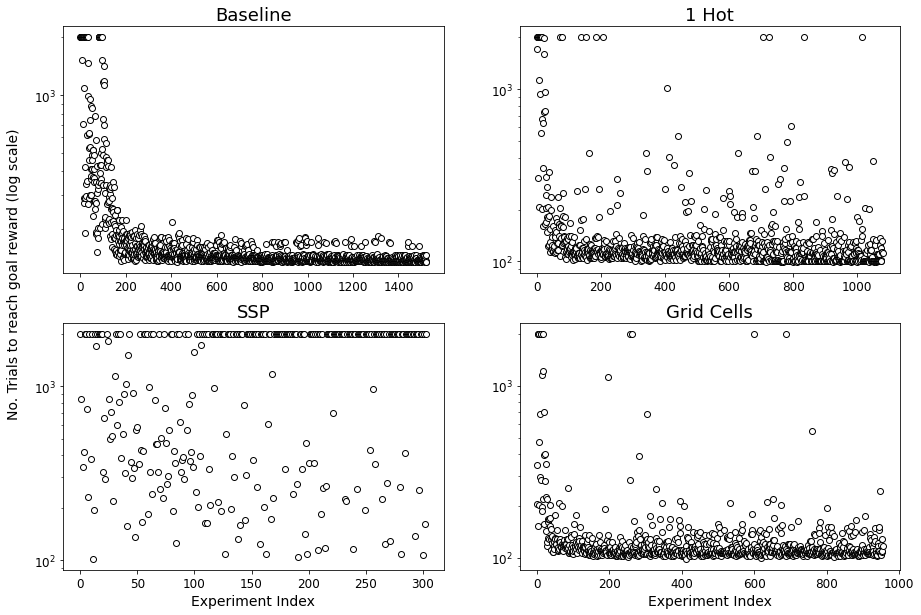

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

ax1.scatter(mg_lam_base.index, mg_lam_base['goal_reached'], color = 'white', edgecolors = 'black')
ax1.set_title('Baseline', fontsize=18)
ax1.set_ylabel('No. Trials to reach goal reward (log scale)', fontsize=14)
ax1.yaxis.set_label_coords(-.11, 0)
ax1.set_yscale('log')
ax1.tick_params(labelsize = 12)

ax2.scatter(mg_lam_1h.index, mg_lam_1h['goal_reached'], color = 'white', edgecolors = 'black')
ax2.set_title('1 Hot', fontsize=18)
ax2.set_yscale('log')
ax2.tick_params(labelsize = 12)

ax3.scatter(mg_lam_ssp.index, mg_lam_ssp['goal_reached'], color = 'white', edgecolors = 'black')
ax3.set_title('SSP', fontsize=18)
ax3.set_xlabel('Experiment Index', fontsize=14)
ax3.set_yscale('log')
ax3.tick_params(labelsize = 12)

ax4.scatter(mg_lam_grid.index, mg_lam_grid['goal_reached'], color = 'white', edgecolors = 'black')
ax4.set_title('Grid Cells', fontsize=18)
ax4.set_xlabel('Experiment Index', fontsize=14)
ax4.set_yscale('log')
ax4.tick_params(labelsize = 12)

## save figure
fig.savefig("./figures/nni_tdlam_optim.pdf", bbox_inches="tight")

Print the minimum number of trials needed to reach goal for each representation

In [26]:
print('Minimum no. trials to reach goal.')
print('   Baseline:', mg_lam_base['goal_reached'].min())
print('   One Hot:', mg_lam_1h['goal_reached'].min())
print('   SSP:', mg_lam_ssp['goal_reached'].min())
print('   Grid Cells:', mg_lam_grid['goal_reached'].min())

Minimum no. trials to reach goal.
   Baseline: 134.0
   One Hot: 99.0
   SSP: 102.0
   Grid Cells: 99.0


### TD($\lambda$) - 'Best' Parameter Value Combinations
<br>
Let's have a look at the 'best' parameter sets - the parameter values that achieved the goal rolling mean in the fewest learning trials

In [27]:
## Create dataframes containing the 'best' 2% of nni experiments 
mg_lam_base_best = get_best(mg_lam_base, ['alpha ', 'beta ', 'gamma ', 'lambd '])
mg_lam_1h_best = get_best(mg_lam_1h, ['alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity '])
mg_lam_ssp_best = get_best(mg_lam_ssp, ['alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity ', 'dims '])
mg_lam_grid_best = get_best(mg_lam_grid, ['alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity '])

Show the experiments that were in this top 2% for each condition

In [28]:
print('Baseline Representation')
print(len(mg_lam_base_best), 'experiments achieved goal in under', mg_lam_base_best['goal_reached'].max(), 'trials.')

param_sets_lam_base = mg_lam_base_best[['index', 'alpha ','beta ','gamma ', 'lambd ', 'goal_reached']]
param_sets_lam_base.drop_duplicates()

Baseline Representation
30 experiments achieved goal in under 134.0 trials.


,index,alpha,beta,gamma,lambd,goal_reached
0,424,0.585849,0.950670,0.995188,0.306209,134.0
1,671,0.591883,0.943486,0.996187,0.299594,134.0
2,705,0.591159,0.950244,0.995944,0.313450,134.0
3,791,0.597655,0.953970,0.996383,0.312909,134.0
4,800,0.592563,0.956776,0.994722,0.315582,134.0
5,844,0.594581,0.954967,0.996718,0.318429,134.0
6,846,0.588696,0.954145,0.995450,0.318921,134.0
7,886,0.594624,0.955216,0.994997,0.316249,134.0
8,887,0.591474,0.956736,0.994914,0.319540,134.0
9,910,0.588657,0.947667,0.996936,0.308859,134.0


In [29]:
print('One-Hot Representation')
print(len(mg_lam_1h_best), 'experiments achieved goal in under', mg_lam_1h_best['goal_reached'].max(), 'trials.')

param_sets_lam_1h = mg_lam_1h_best[['index', 'alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity ', 'goal_reached']]
param_sets_lam_1h.drop_duplicates()

One-Hot Representation
21 experiments achieved goal in under 100.0 trials.


,index,alpha,beta,gamma,lambd,n_neurons,sparsity,goal_reached
0,716,0.085037,0.893673,0.961350,0.989079,520.0,0.298325,99.0
1,761,0.088735,0.898917,0.963988,0.987212,520.0,0.296820,99.0
2,766,0.083775,0.878849,0.960553,0.989667,520.0,0.304264,99.0
3,767,0.085782,0.893757,0.957325,0.990913,520.0,0.303579,99.0
4,801,0.080557,0.893274,0.955895,0.993788,520.0,0.298930,99.0
5,811,0.083691,0.887461,0.960102,0.990174,520.0,0.302808,99.0
6,926,0.090208,0.899457,0.963038,0.987047,520.0,0.301084,99.0
7,948,0.082895,0.892981,0.959694,0.992466,520.0,0.298250,99.0
8,980,0.086212,0.896577,0.963132,0.989487,520.0,0.301281,99.0
9,999,0.086098,0.895623,0.962266,0.989588,520.0,0.293818,99.0


In [30]:
print('SSP Representation')
print(len(mg_lam_ssp_best), 'experiments achieved goal in under', mg_lam_ssp_best['goal_reached'].max(), 'trials.')

param_sets_lam_ssp = mg_lam_ssp_best[['index', 'alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity ', 'dims ', 'goal_reached']]
param_sets_lam_ssp.drop_duplicates()

SSP Representation
6 experiments achieved goal in under 109.0 trials.


,index,alpha,beta,gamma,lambd,n_neurons,sparsity,dims,goal_reached
0,11,0.681962,0.621741,0.846386,0.698546,4480.0,0.618710,64.0,102.0
1,191,0.707935,0.618812,0.849784,0.699780,4480.0,0.637918,64.0,104.0
2,300,0.645390,0.655092,0.832537,0.828999,4117.0,0.552192,256.0,107.0
3,163,0.654019,0.657251,0.835482,0.826070,4117.0,0.554273,256.0,108.0
4,281,0.662396,0.642905,0.802680,0.827262,4117.0,0.539725,256.0,108.0
5,127,0.645576,0.631471,0.834873,0.818766,4117.0,0.592497,64.0,109.0


In [31]:
print('Grid-Cell Representation')
print(len(mg_lam_grid_best), 'experiments achieved goal in under', mg_lam_grid_best['goal_reached'].max(), 'trials.')

param_sets_lam_grid = mg_lam_grid_best[['index', 'alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity ', 'goal_reached']]
param_sets_lam_grid.drop_duplicates()

Grid-Cell Representation
19 experiments achieved goal in under 103.0 trials.


,index,alpha,beta,gamma,lambd,n_neurons,sparsity,goal_reached
0,413,0.376436,0.910458,0.973253,0.616501,2039.0,0.188058,99.0
1,618,0.329007,0.936430,0.985537,0.648743,2039.0,0.174930,100.0
2,251,0.372700,0.888941,0.993209,0.633393,2039.0,0.177811,101.0
3,821,0.366896,0.886989,0.991381,0.637673,2039.0,0.179535,101.0
4,218,0.380535,0.885264,0.983060,0.638754,2039.0,0.175317,102.0
5,239,0.332734,0.936192,0.983706,0.652498,2039.0,0.170592,102.0
6,371,0.368859,0.891030,0.978224,0.627641,2039.0,0.175728,102.0
7,377,0.372363,0.903886,0.984120,0.616195,2039.0,0.177742,102.0
8,406,0.360694,0.895813,0.984589,0.617445,2039.0,0.180707,102.0
9,507,0.326177,0.929660,0.982166,0.662115,2039.0,0.168840,102.0


Table of Ranges -- create a table showing the range of values in the top 2% for each parameter

In [32]:
param_sets_lam_combined = pd.DataFrame(columns=['alpha_range', 'beta_range', 'gamma_range', 'lambda_range', 
                                                'neurons_range', 'sparsity_range', 'dims_range', 'nTrials_range'], 
                                  index=['TDLam_Base', 'TDLam_1H', 'TDLam_SSP', 'TDLam_Grid'])

param_sets_lam_combined.loc['TDLam_Base','alpha_range'] = param_sets_lam_base['alpha '].min(), param_sets_lam_base['alpha '].max()
param_sets_lam_combined.loc['TDLam_Base','beta_range'] = param_sets_lam_base['beta '].min(), param_sets_lam_base['beta '].max()
param_sets_lam_combined.loc['TDLam_Base','gamma_range'] = param_sets_lam_base['gamma '].min(), param_sets_lam_base['gamma '].max()
param_sets_lam_combined.loc['TDLam_Base','lambda_range'] = param_sets_lam_base['lambd '].min(), param_sets_lam_base['lambd '].max()
param_sets_lam_combined.loc['TDLam_Base','nTrials_range'] = param_sets_lam_base['goal_reached'].min(), param_sets_lam_base['goal_reached'].max()

param_sets_lam_combined.loc['TDLam_1H','alpha_range'] = param_sets_lam_1h['alpha '].min(), param_sets_lam_1h['alpha '].max()
param_sets_lam_combined.loc['TDLam_1H','beta_range'] = param_sets_lam_1h['beta '].min(), param_sets_lam_1h['beta '].max()
param_sets_lam_combined.loc['TDLam_1H','gamma_range'] = param_sets_lam_1h['gamma '].min(), param_sets_lam_1h['gamma '].max()
param_sets_lam_combined.loc['TDLam_1H','lambda_range'] = param_sets_lam_1h['lambd '].min(), param_sets_lam_1h['lambd '].max()
param_sets_lam_combined.loc['TDLam_1H','neurons_range'] = param_sets_lam_1h['n_neurons '].min(), param_sets_lam_1h['n_neurons '].max()
param_sets_lam_combined.loc['TDLam_1H','sparsity_range'] = param_sets_lam_1h['sparsity '].min(), param_sets_lam_1h['sparsity '].max()
param_sets_lam_combined.loc['TDLam_1H','nTrials_range'] = param_sets_lam_1h['goal_reached'].min(), param_sets_lam_1h['goal_reached'].max()

param_sets_lam_combined.loc['TDLam_SSP','alpha_range'] = param_sets_lam_ssp['alpha '].min(), param_sets_lam_ssp['alpha '].max()
param_sets_lam_combined.loc['TDLam_SSP','beta_range'] = param_sets_lam_ssp['beta '].min(), param_sets_lam_ssp['beta '].max()
param_sets_lam_combined.loc['TDLam_SSP','gamma_range'] = param_sets_lam_ssp['gamma '].min(), param_sets_lam_ssp['gamma '].max()
param_sets_lam_combined.loc['TDLam_SSP','lambda_range'] = param_sets_lam_ssp['lambd '].min(), param_sets_lam_ssp['lambd '].max()
param_sets_lam_combined.loc['TDLam_SSP','neurons_range'] = param_sets_lam_ssp['n_neurons '].min(), param_sets_lam_ssp['n_neurons '].max()
param_sets_lam_combined.loc['TDLam_SSP','sparsity_range'] = param_sets_lam_ssp['sparsity '].min(), param_sets_lam_ssp['sparsity '].max()
param_sets_lam_combined.loc['TDLam_SSP','dims_range'] = param_sets_lam_ssp['dims '].min(), param_sets_lam_ssp['dims '].max()
param_sets_lam_combined.loc['TDLam_SSP','nTrials_range'] = param_sets_lam_ssp['goal_reached'].min(), param_sets_lam_ssp['goal_reached'].max()

param_sets_lam_combined.loc['TDLam_Grid','alpha_range'] = param_sets_lam_grid['alpha '].min(), param_sets_lam_grid['alpha '].max()
param_sets_lam_combined.loc['TDLam_Grid','beta_range'] = param_sets_lam_grid['beta '].min(), param_sets_lam_grid['beta '].max()
param_sets_lam_combined.loc['TDLam_Grid','gamma_range'] = param_sets_lam_grid['gamma '].min(), param_sets_lam_grid['gamma '].max()
param_sets_lam_combined.loc['TDLam_Grid','lambda_range'] = param_sets_lam_grid['lambd '].min(), param_sets_lam_grid['lambd '].max()
param_sets_lam_combined.loc['TDLam_Grid','neurons_range'] = param_sets_lam_grid['n_neurons '].min(), param_sets_lam_grid['n_neurons '].max()
param_sets_lam_combined.loc['TDLam_Grid','sparsity_range'] = param_sets_lam_grid['sparsity '].min(), param_sets_lam_grid['sparsity '].max()
param_sets_lam_combined.loc['TDLam_Grid','nTrials_range'] = param_sets_lam_grid['goal_reached'].min(), param_sets_lam_grid['goal_reached'].max()
param_sets_lam_combined

,alpha_range,beta_range,gamma_range,lambda_range,neurons_range,sparsity_range,dims_range,nTrials_range
TDLam_Base,"(0.5858492255210876, 0.597655177116394)","(0.943303644657135, 0.9615065455436707)","(0.9932087659835815, 0.9979659914970398)","(0.2995937168598175, 0.3264952301979065)",NaN,NaN,NaN,"(134.0, 134.0)"
TDLam_1H,"(0.07788217067718506, 0.09020844846963882)","(0.8689894080162048, 0.9008899927139282)","(0.9525527358055115, 0.9645271897315979)","(0.9858989119529724, 0.9951751828193665)","(520.0, 520.0)","(0.2938176989555359, 0.312633216381073)",NaN,"(99.0, 100.0)"
TDLam_SSP,"(0.645389974117279, 0.7079352736473083)","(0.6188123226165771, 0.657250702381134)","(0.8026803135871887, 0.8497835397720337)","(0.6985461711883545, 0.8289990425109863)","(4117.0, 4480.0)","(0.539724588394165, 0.6379182934761047)","(64.0, 256.0)","(102.0, 109.0)"
TDLam_Grid,"(0.3229360580444336, 0.38418951630592346)","(0.8656088709831238, 0.9464927315711975)","(0.9607516527175903, 0.9932087063789368)","(0.6161946058273315, 0.6728034019470215)","(2039.0, 2039.0)","(0.167698934674263, 0.1930520236492157)",NaN,"(99.0, 103.0)"


Find all instances of these parameter value combinations and plot the number of trials to reach goal. This plot illustrates the stability of these parameter value combinations

In [33]:
## Create data frames containing experiments that tested value combinations 
## that were inside the ranges used in the top 2% experiments
in_range_lam_base = get_all_best_params(mg_lam_base, param_sets_lam_base, ['alpha ', 'beta ', 'gamma ', 'lambd '])
in_range_lam_1h = get_all_best_params(mg_lam_1h, param_sets_lam_1h, ['alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity '])
in_range_lam_ssp = get_all_best_params(mg_lam_ssp, param_sets_lam_ssp, ['alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity ', 'dims '])
in_range_lam_grid = get_all_best_params(mg_lam_grid, param_sets_lam_grid, ['alpha ', 'beta ', 'gamma ', 'lambd ', 'n_neurons ', 'sparsity '])

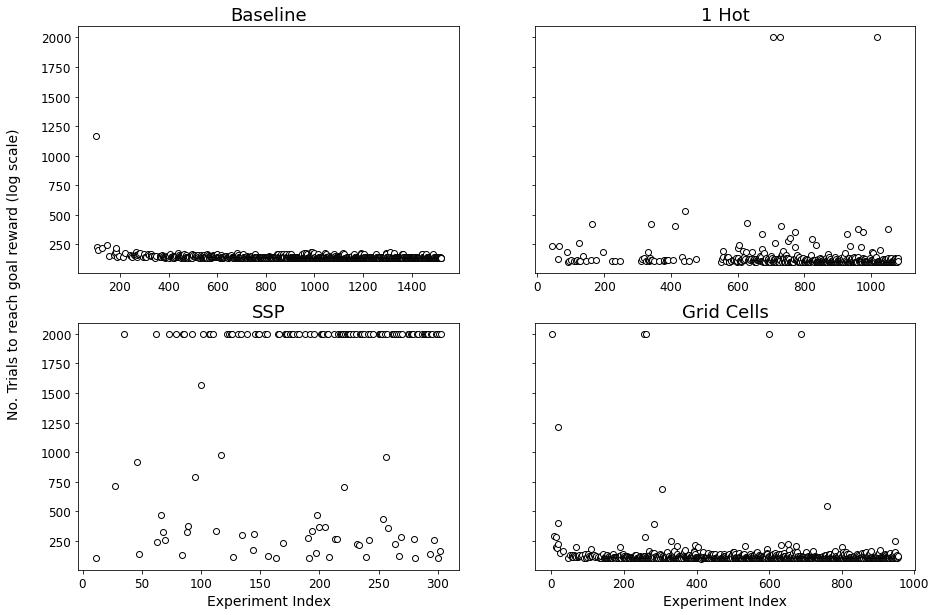

In [34]:
## Plot trials to reach goal for all of these experiments
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharey=True)

ax1.scatter(in_range_lam_base.index, in_range_lam_base['goal_reached'], color = 'white', edgecolors = 'black')
ax1.set_title('Baseline', fontsize=18)
ax1.set_ylabel('No. Trials to reach goal reward (log scale)', fontsize=14)
ax1.yaxis.set_label_coords(-.15, 0)
ax1.tick_params(labelsize=12)
#ax1.set_yscale('log')

ax2.scatter(in_range_lam_1h.index, in_range_lam_1h['goal_reached'], color = 'white', edgecolors = 'black')
ax2.set_title('1 Hot', fontsize=18)
ax2.tick_params(labelsize=12)
#ax2.set_yscale('log')

ax3.scatter(in_range_lam_ssp.index, in_range_lam_ssp['goal_reached'], color = 'white', edgecolors = 'black')
ax3.set_title('SSP', fontsize=18)
ax3.set_xlabel('Experiment Index', fontsize=14)
ax3.tick_params(labelsize=12)
#ax3.set_yscale('log')

ax4.scatter(in_range_lam_grid.index, in_range_lam_grid['goal_reached'], color = 'white', edgecolors = 'black')
ax4.set_title('Grid Cells', fontsize=18)
ax4.set_xlabel('Experiment Index', fontsize=14)
ax4.tick_params(labelsize=12)
#ax4.set_yscale('log')

## Save figure
fig.savefig("./figures/nni_tdlam_bestparams.pdf", bbox_inches="tight")

Finally, we need to make sure that once the goal was reached, the network continued getting rewards

In [35]:
## Extract just the reward schedules for the best 2% experiments
mg_lam_base_best = get_best_reward_schedules(mg_lam_base_best)
mg_lam_1h_best = get_best_reward_schedules(mg_lam_1h_best)
mg_lam_ssp_best = get_best_reward_schedules(mg_lam_ssp_best)
mg_lam_grid_best = get_best_reward_schedules(mg_lam_grid_best)

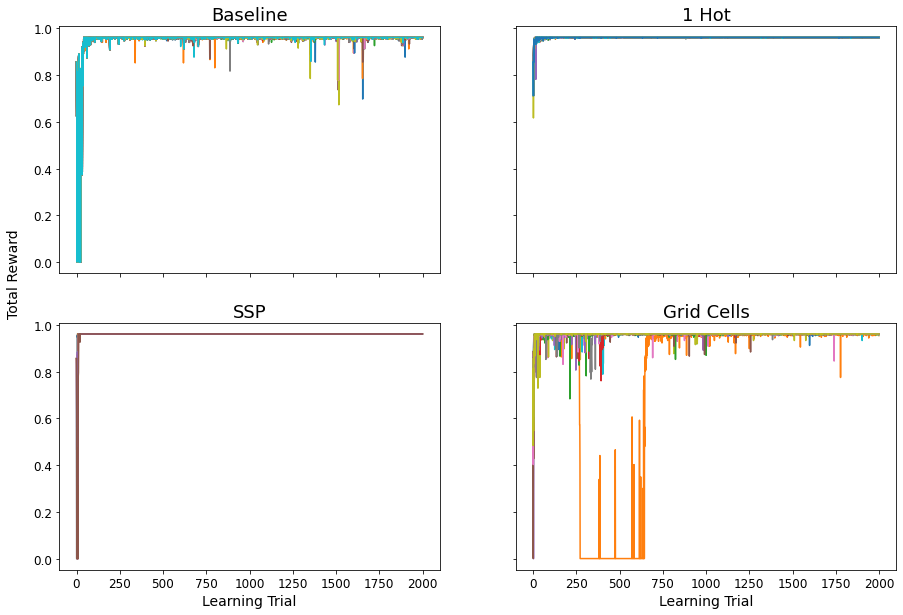

In [36]:
## Plot the reward schedules for each experiment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharey=True, sharex = True)

for i in range(len(mg_lam_base_best)):
    ax1.plot(mg_lam_base_best['episodes '][i])
ax1.set_title('Baseline', fontsize=18)
ax1.set_ylabel('Total Reward', fontsize=14)
ax1.yaxis.set_label_coords(-.1, 0)
ax1.tick_params(labelsize=12)

for i in range(len(mg_lam_1h_best)):
    ax2.plot(mg_lam_1h_best['episodes '][i])
ax2.set_title('1 Hot', fontsize=18)
ax2.tick_params(labelsize=12)
    
for i in range(len(mg_lam_ssp_best)):
    ax3.plot(mg_lam_ssp_best['episodes '][i])
ax3.set_title('SSP', fontsize=18)
ax3.set_xlabel('Learning Trial', fontsize=14)
ax3.tick_params(labelsize=12)
    
for i in range(len(mg_lam_grid_best)):
    ax4.plot(mg_lam_grid_best['episodes '][i])
ax4.set_title('Grid Cells', fontsize=18)
ax4.set_xlabel('Learning Trial', fontsize=14)
ax4.tick_params(labelsize=12)

## Save figure
fig.savefig("./figures/nni_tdlam_rewards.pdf", bbox_inches="tight")

## Combined Plots for the Paper

### Optimization Curves

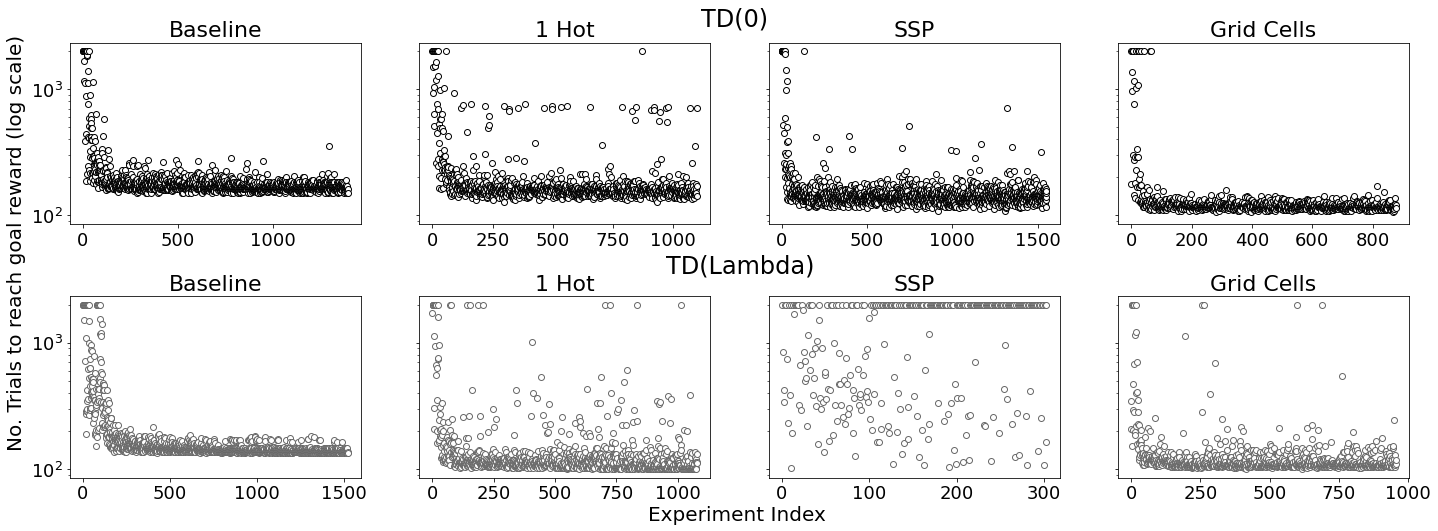

In [37]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24,8), sharey=True)
#fig.suptitle('Optimization Curves', fontsize=24)
fig.text(0.49, 0.91, "TD(0)", fontsize = 24)

ax1.scatter(mg_0_base.index, mg_0_base['goal_reached'], color = 'white', edgecolors = 'black')
ax1.set_title('Baseline', fontsize=22)
ax1.set_ylabel('No. Trials to reach goal reward (log scale)', fontsize=20)
ax1.yaxis.set_label_coords(-.15, -.1)
ax1.set_yscale('log')
ax1.tick_params(labelsize = 18)

ax2.scatter(mg_0_1h.index, mg_0_1h['goal_reached'], color = 'white', edgecolors = 'black')
ax2.set_title('1 Hot', fontsize=22)
ax2.set_yscale('log')
ax2.tick_params(labelsize = 18)

ax3.scatter(mg_0_ssp.index, mg_0_ssp['goal_reached'], color = 'white', edgecolors = 'black')
ax3.set_title('SSP', fontsize=22)
ax3.set_yscale('log')
ax3.tick_params(labelsize = 18)

ax4.scatter(mg_0_grid.index, mg_0_grid['goal_reached'], color = 'white', edgecolors = 'black')
ax4.set_title('Grid Cells', fontsize=22)
ax4.set_yscale('log')
ax4.tick_params(labelsize = 18)

fig.text(0.47, 0.48, "TD(Lambda)", fontsize = 24)

ax5.scatter(mg_lam_base.index, mg_lam_base['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax5.set_title('Baseline', fontsize=22)
ax5.set_yscale('log')
ax5.tick_params(labelsize = 18)

ax6.scatter(mg_lam_1h.index, mg_lam_1h['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax6.set_title('1 Hot', fontsize=22)
ax6.set_yscale('log')
ax6.tick_params(labelsize = 18)

ax7.scatter(mg_lam_ssp.index, mg_lam_ssp['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax7.set_title('SSP', fontsize=22)
ax7.set_xlabel('Experiment Index', fontsize=20)
ax7.xaxis.set_label_coords(-.11, -.15)
ax7.set_yscale('log')
ax7.tick_params(labelsize = 18)

ax8.scatter(mg_lam_grid.index, mg_lam_grid['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax8.set_title('Grid Cells', fontsize=22)
ax8.set_yscale('log')
ax8.tick_params(labelsize = 18)

plt.subplots_adjust(hspace=0.4)

## Save figure
fig.savefig("./figures/nni_combined_optim.pdf", bbox_inches="tight")

### Best Params

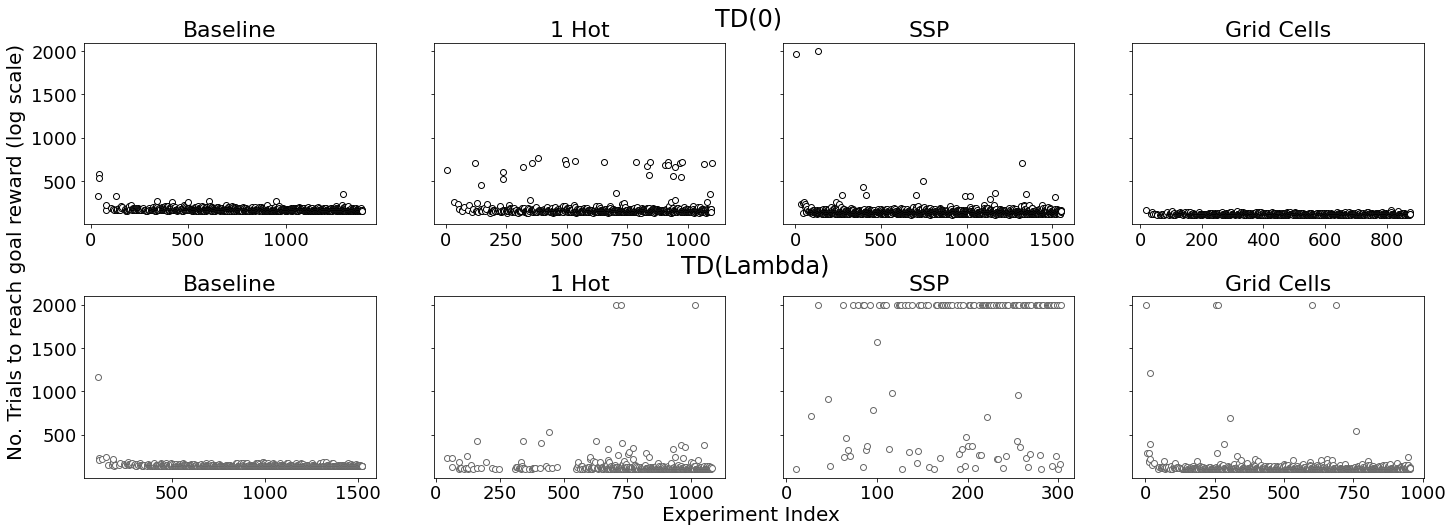

In [38]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24,8), sharey=True)
#fig.suptitle('Performance with Best Parameters', fontsize=24)
fig.text(0.49, 0.91, "TD(0)", fontsize = 24)

ax1.scatter(in_range_base.index, in_range_base['goal_reached'], color = 'white', edgecolors = 'black')
ax1.set_title('Baseline', fontsize=22)
ax1.set_ylabel('No. Trials to reach goal reward (log scale)', fontsize=20)
ax1.yaxis.set_label_coords(-.2, -.15)
ax1.tick_params(labelsize = 18)
#ax1.set_yscale('log')

ax2.scatter(in_range_1h.index, in_range_1h['goal_reached'], color = 'white', edgecolors = 'black')
ax2.set_title('1 Hot', fontsize=22)
ax2.tick_params(labelsize = 18)
#ax2.set_yscale('log')

ax3.scatter(in_range_ssp.index, in_range_ssp['goal_reached'], color = 'white', edgecolors = 'black')
ax3.set_title('SSP', fontsize=22)
#ax3.set_xlabel('Experiment index', fontsize=14)
ax3.tick_params(labelsize = 18)
#ax3.set_yscale('log')

ax4.scatter(in_range_grid.index, in_range_grid['goal_reached'], color = 'white', edgecolors = 'black')
ax4.set_title('Grid Cells', fontsize=22)
#ax4.set_xlabel('Experiment index', fontsize=14)
ax4.tick_params(labelsize = 18)
#ax4.set_yscale('log')

fig.text(0.47, 0.48, "TD(Lambda)", fontsize = 24)

ax5.scatter(in_range_lam_base.index, in_range_lam_base['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax5.set_title('Baseline', fontsize=22)
ax5.tick_params(labelsize=18)
#ax5.set_yscale('log')

ax6.scatter(in_range_lam_1h.index, in_range_lam_1h['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax6.set_title('1 Hot', fontsize=22)
ax6.tick_params(labelsize=18)
#ax6.set_yscale('log')

ax7.scatter(in_range_lam_ssp.index, in_range_lam_ssp['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax7.set_title('SSP', fontsize=22)
ax7.set_xlabel('Experiment Index', fontsize=20)
ax7.xaxis.set_label_coords(-.11, -.15)
ax7.tick_params(labelsize=18)
#ax7.set_yscale('log')

ax8.scatter(in_range_lam_grid.index, in_range_lam_grid['goal_reached'], color = 'white', edgecolors = 'dimgrey')
ax8.set_title('Grid Cells', fontsize=22)
#ax8.set_xlabel('Experiment index', fontsize=14)
ax8.tick_params(labelsize=18)
#ax4.set_yscale('log')

plt.subplots_adjust(hspace=0.4)

## Save figure
fig.savefig("./figures/nni_combined_bestparams.pdf", bbox_inches="tight")